# Vacancy formation energy and volume from implicit derivative

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.interpolate import CubicSpline

# Local imports
from lammps_implicit_der import LammpsImplicitDer, SNAP
from lammps_implicit_der.tools import mpi_print, initialize_mpi, TimingGroup, plot_tools, \
                                      compute_energy_volume, create_perturbed_system, run_npt_implicit_derivative
from lammps_implicit_der.tools.error_tools import coord_error
from lammps_implicit_der.systems import BccVacancy, Bcc
#from lammps_implicit_der.tools.error_tools import coord_error

plotparams = plot_tools.plotparams.copy()
plotparams['figure.figsize'] = (9, 6)
plotparams['font.size'] = 16
plotparams['figure.subplot.wspace'] = 0.2
plt.rcParams.update(plotparams)

# Create the W bcc pure and vacancy systems

In [2]:
ncell_x = 2
alat = 3.18427
alat_vac = 3.163

bcc_pure = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

print(f'{bcc_pure.Natom=}')
print(f'{bcc_pure.energy=:.3f}')
print(f'{bcc_vac.Natom=}')
print(f'{bcc_vac.energy=:.3f}')

bcc_pure.Natom=16
bcc_pure.energy=-89.061
bcc_vac.Natom=15
bcc_vac.energy=-80.365


## Energy-volume curve

In [3]:
epsilon_array = np.linspace(-0.05, 0.05, 61)
bcc_pure_tmp = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac_tmp = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

energy_array_pure, volume_array_pure, virial_array_pure, pressure_array_pure = compute_energy_volume(bcc_pure_tmp, epsilon_array)
energy_array_vac, volume_array_vac, virial_array_vac, pressure_array_vac = compute_energy_volume(bcc_vac_tmp, epsilon_array)

In [4]:
def get_min(energy_array, volume_array, pressure_array, ncell_x):
    min_idx = np.argmin(energy_array)

    energy_min = energy_array[min_idx]
    volume_min = volume_array[min_idx]
    pressure_min = pressure_array[min_idx]

    alat_min = volume_min**(1/3) / ncell_x

    return energy_min, volume_min, pressure_min, alat_min

energy_pure_min, volume_pure_min, pressure_pure_min, alat_pure_min = \
    get_min(energy_array_pure, volume_array_pure, pressure_array_pure, ncell_x)

print('Pure bcc:')
print(f'{energy_pure_min=:.3f}')
print(f'{volume_pure_min=:.3f}')
print(f'{pressure_pure_min=:.3f}')
print(f'{alat_pure_min=:.3f}')
print('')

energy_vac_min, volume_vac_min, pressure_vac_min, alat_vac_min = \
    get_min(energy_array_vac, volume_array_vac, pressure_array_vac, ncell_x)

print('Vacancy bcc:')
print(f'{energy_vac_min=:.3f}')
print(f'{volume_vac_min=:.3f}')
print(f'{pressure_vac_min=:.3f}')
print(f'{alat_vac_min=:.3f}')

Pure bcc:
energy_pure_min=0.000
volume_pure_min=258.297
pressure_pure_min=-0.003
alat_pure_min=3.184

Vacancy bcc:
energy_vac_min=0.000
volume_vac_min=253.156
pressure_vac_min=0.081
alat_vac_min=3.163


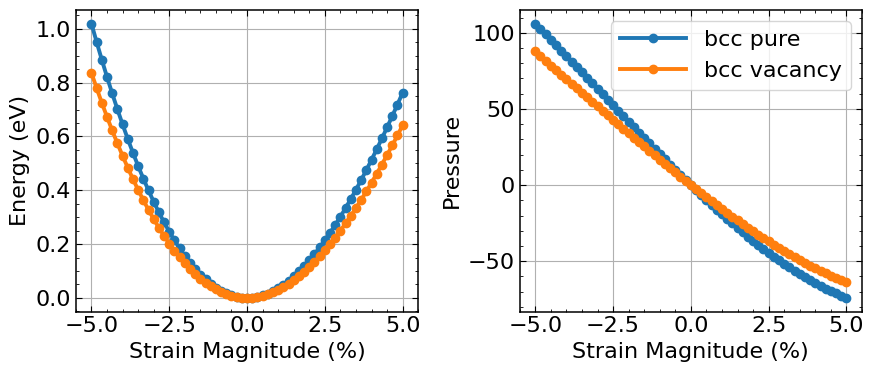

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

ms = 6
axes[0].plot(100.0 * epsilon_array, energy_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[0].plot(100.0 * epsilon_array, energy_array_vac, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[0].set_xlabel('Strain Magnitude (%)')
axes[0].set_ylabel('Energy (eV)')

axes[1].plot(100.0 * epsilon_array, pressure_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[1].plot(100.0 * epsilon_array, pressure_array_vac, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[1].set_xlabel('Strain Magnitude (%)')
axes[1].set_ylabel('Pressure')
axes[1].legend()

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

## Interpolation of virial and its derivative

In [6]:
spline_list_pure = []
spline_list_vac = []

for idesc in range(bcc_pure.Ndesc):

    virial_trace_array_pure = np.sum(virial_array_pure[:, :3, :], axis=1) / 3.0
    spline_list_pure.append(CubicSpline(volume_array_pure, virial_trace_array_pure[:, idesc]))

    virial_trace_array_vac = np.sum(virial_array_vac[:, :3, :], axis=1) / 3.0
    spline_list_vac.append(CubicSpline(volume_array_vac, virial_trace_array_vac[:, idesc]))

virial_der_pure0 = np.array([spline_list_pure[idesc](volume_pure_min, nu=1) for idesc in range(bcc_pure.Ndesc)])
virial_der_vac0 = np.array([spline_list_vac[idesc](volume_vac_min, nu=1) for idesc in range(bcc_vac.Ndesc)])

# Perturb parameters and compute formation volumes and energies

### Implicit derivative - inhomogeneous contribution

In [7]:
# Re-define the same systems
bcc_pure = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

dX_dTheta_pure_inhom = bcc_pure.implicit_derivative(method='inverse')
dX_dTheta_vac_inhom = bcc_vac.implicit_derivative(method='inverse')

bcc_pure.compute_virial()
bcc_pure.gather_virial()
virial_pure = np.sum(bcc_pure.virial, axis=0)
virial_trace_pure = np.sum(virial_pure[:3, :], axis=0) / 3.0

bcc_vac.compute_virial()
bcc_vac.gather_virial()
virial_vac = np.sum(bcc_vac.virial, axis=0)
virial_trace_vac = np.sum(virial_vac[:3, :], axis=0) / 3.0

### Ensemble of Tungsten potentials

In [8]:
path = '../lammps_implicit_der/data_files/'
filename = 'Theta_ens.pkl'
with open(os.path.join(path, filename), 'rb') as file:
    Theta_ens = pickle.load(file)

In [27]:
sample = 1
data_path = '../lammps_implicit_der/data_files/'
snapcoeff_filename = 'W_NEW.snapcoeff'
snapparam_filename ='W_NEW.snapparam'

#delta_array = np.linspace(-20.0, 20.0, 5)
delta_array = np.array([-25.0, -10.0, 0.0, 10.0, 25.0, 50.0, 100.0])
ndelta = len(delta_array)

bcc_pure_list = []
bcc_vac_list = []

for i, delta in enumerate(delta_array):
    print('\n'+'*'*80)
    print(f'{i+1}/{len(delta_array)}, {delta=:.1f}')
    #print('Pure:')
    bcc_pure_list.append(run_npt_implicit_derivative(Bcc, alat, ncell_x, Theta_ens, delta, sample,
                                                     data_path, snapcoeff_filename, snapparam_filename,
                                                     virial_trace_pure, virial_der_pure0,
                                                     dX_dTheta_pure_inhom, dX_dTheta_full=None))

    #print('Vacancy:')
    bcc_vac_list.append(run_npt_implicit_derivative(BccVacancy, alat_vac, ncell_x, Theta_ens, delta, sample,
                                                    data_path, snapcoeff_filename, snapparam_filename,
                                                    virial_trace_vac, virial_der_vac0,
                                                    dX_dTheta_vac_inhom, dX_dTheta_full=None))


********************************************************************************
1/7, delta=-25.0
Overwriting ./perturb.snapcoeff
Saved SNAP coefficients to ./perturb.snapcoeff
Saved SNAP parameters to ./perturb.snapparam

--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log perturb.log

Setting SNAP potential

                  SNAP coefficients for: W
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: True 

Minimization finished in 6 steps
Initial fmax: 1.169e-14, final fmax: 2.082e-14
Initial fnorm: 4.525e-14, final fnorm: 7.826e-14
Number of atoms: 16, largest force value: 2.082e-14, force norm: 7.826e-14
s_box_relax.pot.Theta_dict[el]['beta0']=0.0
s_test.pot.Theta_dict[el]['beta0']=0.0
energy0=-89.060889667491

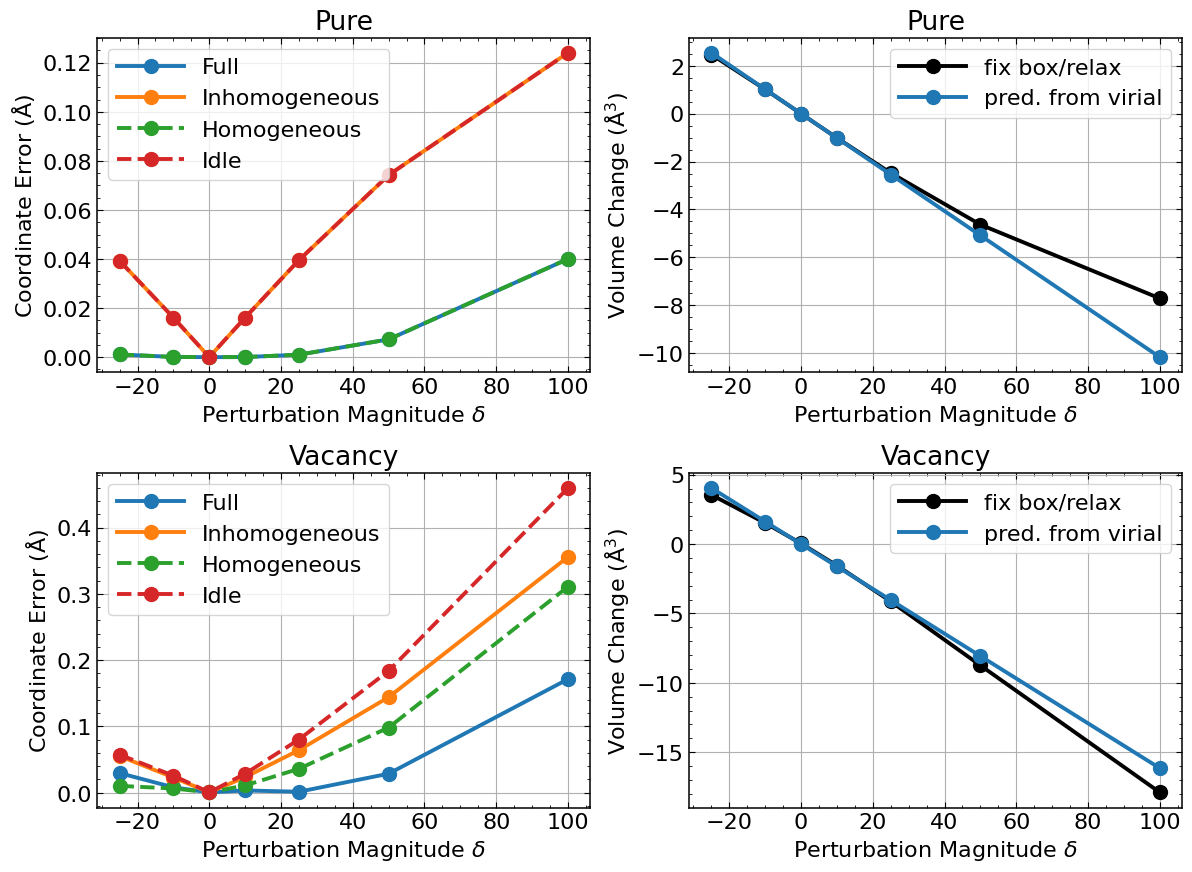

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.3)

error_axes = [axes[0, 0], axes[1, 0]]
data_lists = [bcc_pure_list, bcc_vac_list]
title_list = ['Pure', 'Vacancy']

for i, (data_list, ax) in enumerate(zip(data_lists, error_axes)):

    ax.plot(delta_array,
            [data_list[i]['coord_error_full'] for i in range(ndelta)],
            label='Full', marker='o')
    ax.plot(delta_array,
            [data_list[i]['coord_error_inhom'] for i in range(ndelta)],
            label='Inhomogeneous', marker='o')
    ax.plot(delta_array,
            [data_list[i]['coord_error_hom'] for i in range(ndelta)],
            label='Homogeneous', marker='o', ls='--')
    ax.plot(delta_array,
            [data_list[i]['coord_error_idle'] for i in range(ndelta)],
            label='Idle', ls='--', marker='o')

    ax.set_xlabel('Perturbation Magnitude $\delta$')
    ax.set_ylabel('Coordinate Error ($\mathrm{\AA}$)')
    ax.grid()
    ax.legend()

    ax.set_title(title_list[i])

vol_axes = [axes[0, 1], axes[1, 1]]

for i, (data_list, ax) in enumerate(zip(data_lists, vol_axes)):

    vol0 = data_list[i]['volume0']
    ax.plot(delta_array,
            [data_list[i]['volume_true'] - vol0 for i in range(ndelta)],
            label='fix box/relax', marker='o', c='black')
    ax.plot(delta_array,
            [data_list[i]['volume_pred'] - vol0 for i in range(ndelta)],
            label='pred. from virial', marker='o', c='tab:blue')

    ax.set_xlabel('Perturbation Magnitude $\delta$')
    ax.set_ylabel('Volume Change ($\mathrm{\AA}^3$)')
    ax.grid()
    ax.legend()

    ax.set_title(title_list[i])

plt.show()

In [29]:
def compute_formation_property(Natom_vac, Natom_pure, vac_list, pure_list, property_name):

    ndelta = len(vac_list)
    prop_pure = np.array([pure_list[i][property_name] for i in range(ndelta)])
    prop_vac = np.array([vac_list[i][property_name] for i in range(ndelta)])
    #print(f'{prop_vac=} {prop_pure=} {Natom_vac=} {Natom_pure=}')
    prop_formation = prop_vac - prop_pure * Natom_vac / Natom_pure

    return prop_formation

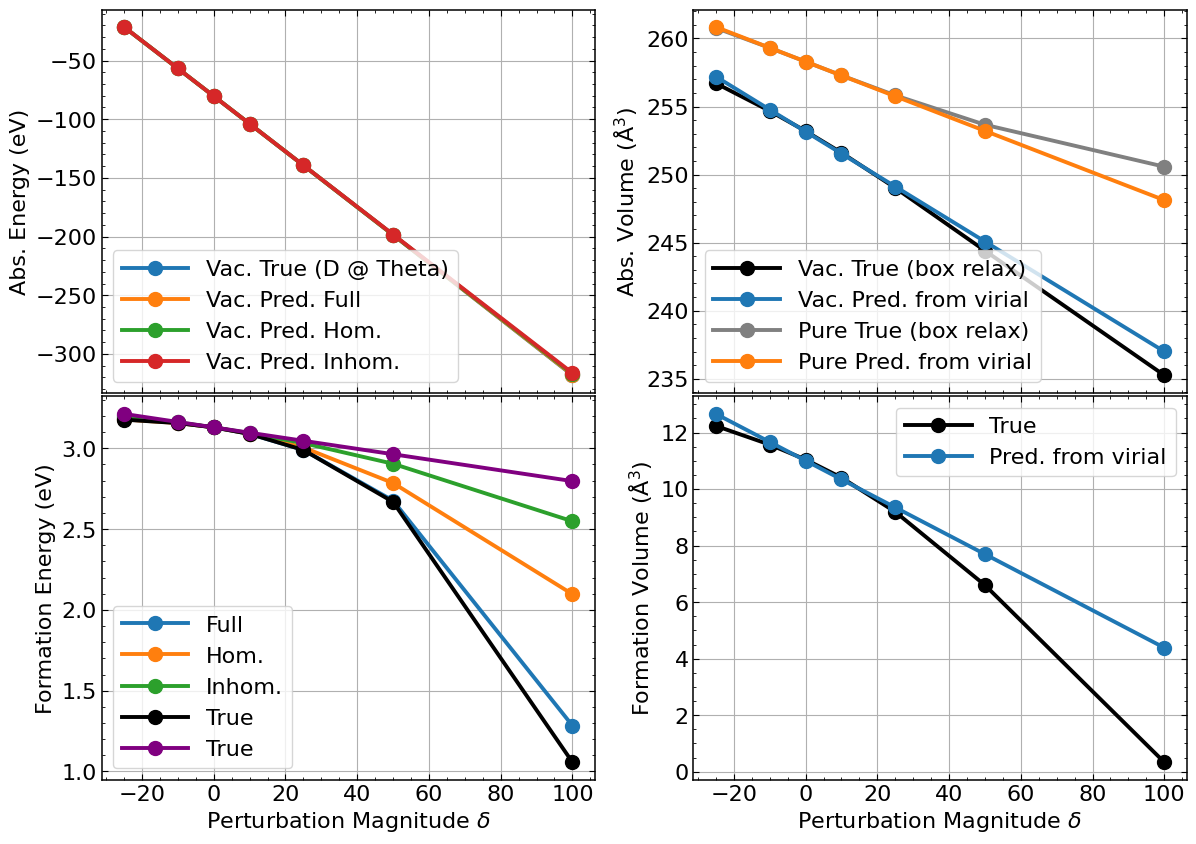

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Absolute energy
#plot_energy_true = True
plot_energy_true = False
if plot_energy_true:
    axes[0, 0].plot(delta_array,
                    [bcc_vac_list[i]['energy_true'] for i in range(ndelta)],
                    label='Vac. True (box relax)', marker='o', c='black')

plot_energy_true2 = True
#plot_energy_true2 = False
if plot_energy_true2:
    axes[0, 0].plot(delta_array,
                    [bcc_vac_list[i]['energy_true2'] for i in range(ndelta)],
                    label='Vac. True (D @ Theta)', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_full_pred2'] for i in range(ndelta)],
                label='Vac. Pred. Full', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_hom_pred2'] for i in range(ndelta)],
                label='Vac. Pred. Hom.', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_inhom_pred2'] for i in range(ndelta)],
                label='Vac. Pred. Inhom.', marker='o')

#axes[0, 0].set_xlabel('Perturbation Magnitude $\delta$')
# remove tick labels
axes[0, 0].set_xticklabels([])
axes[0, 0].set_ylabel('Abs. Energy (eV)')

# Formation energies
Natom_pure = bcc_pure.Natom
Natom_vac = bcc_vac.Natom
E_form_full_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_full_pred2')
E_form_hom_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_hom_pred2')
E_form_inhom_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_inhom_pred2')
E_form_true = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_true2')
E_form_pred0 = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_pred0')

axes[1, 0].plot(delta_array, E_form_full_pred, label='Full', marker='o')
axes[1, 0].plot(delta_array, E_form_hom_pred, label='Hom.', marker='o')
axes[1, 0].plot(delta_array, E_form_inhom_pred, label='Inhom.', marker='o')
axes[1, 0].plot(delta_array, E_form_true, label='True', marker='o', c='black')
axes[1, 0].plot(delta_array, E_form_pred0, label='True', marker='o', c='purple')

axes[1, 0].set_xlabel('Perturbation Magnitude $\delta$')
axes[1, 0].set_ylabel('Formation Energy (eV)')

# Absolute volume
axes[0, 1].plot(delta_array,
          [bcc_vac_list[i]['volume_true'] for i in range(ndelta)],
          label='Vac. True (box relax)', marker='o', c='black')

axes[0, 1].plot(delta_array,
          [bcc_vac_list[i]['volume_pred'] for i in range(ndelta)],
          label='Vac. Pred. from virial', marker='o')

axes[0, 1].plot(delta_array,
          [bcc_pure_list[i]['volume_true'] for i in range(ndelta)],
          label='Pure True (box relax)', marker='o', c='gray')

axes[0, 1].plot(delta_array,
          [bcc_pure_list[i]['volume_pred'] for i in range(ndelta)],
          label='Pure Pred. from virial', marker='o')


axes[0, 1].set_xticklabels([])
axes[0, 1].set_ylabel('Abs. Volume ($\mathrm{\AA}^3$)')

# Formation volume
vol_form_full_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'volume_pred')
vol_form_true = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'volume_true')

axes[1, 1].plot(delta_array, vol_form_true, label='True', marker='o', c='black')
axes[1, 1].plot(delta_array, vol_form_full_pred, label='Pred. from virial', marker='o')

axes[1, 1].set_xlabel('Perturbation Magnitude $\delta$')
axes[1, 1].set_ylabel('Formation Volume ($\mathrm{\AA}^3$)')

for ax in axes.flatten():
    ax.grid()
    ax.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


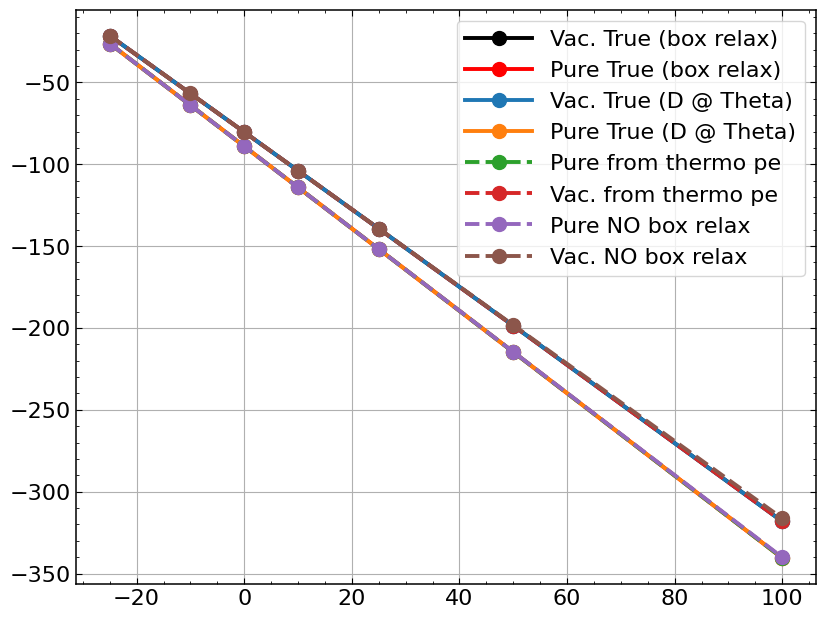

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Makes axes[0, 0] the largest and hide the other axes
for ax in axes.flatten():
    ax.set_visible(False)

axes[0, 0].set_visible(True)

# change the axes[0, 0] size
pos1 = axes[0, 0].get_position() # get the original position
pos2 = [pos1.x0, pos1.y0,  pos1.width*1.5, pos1.height*1.5]
axes[0, 0].set_position(pos2)

# Absolute energy

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_true'] for i in range(ndelta)],
                label='Vac. True (box relax)', marker='o', c='black')

axes[0, 0].plot(delta_array,
                [bcc_pure_list[i]['energy_true'] for i in range(ndelta)],
                label='Pure True (box relax)', marker='o', c='red')


axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_true2'] for i in range(ndelta)],
                label='Vac. True (D @ Theta)', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_pure_list[i]['energy_true2'] for i in range(ndelta)],
                label='Pure True (D @ Theta)', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_pure_list[i]['energy_true3'] for i in range(ndelta)],
                label='Pure from thermo pe', marker='o', ls='--')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_true3'] for i in range(ndelta)],
                label='Vac. from thermo pe', marker='o', ls='--')

axes[0, 0].plot(delta_array,
                [bcc_pure_list[i]['energy_test'] for i in range(ndelta)],
                label='Pure NO box relax', marker='o', ls='--')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_test'] for i in range(ndelta)],
                label='Vac. NO box relax', marker='o', ls='--')

for ax in axes.flatten():
    ax.grid()
    ax.legend()

plt.show()

In [14]:
element = bcc_pure.pot.elem_list[0]
print(bcc_pure.pot.Theta_dict[element]['beta0'])

0.0


In [15]:
def create_perturbed_system_tmp(Theta_ens, delta, LammpsClass, snapcoeff_filename, snapparam_filename=None,
                            data_path=None, sample=1, alat=3.185, ncell_x=2, logname='perturb.log', fix_box_relax=False, minimize=True, verbose=False):

    # system_tmp is created only to save the SNAP potential files
    system_tmp = LammpsClass(data_path=data_path, snapcoeff_filename=snapcoeff_filename, snapparam_filename=snapparam_filename,
                             ncell_x=ncell_x, alat=alat, logname='tmp.log', minimize=False, verbose=False)

    if len(system_tmp.pot.elem_list) > 1:
        raise RuntimeError('Implemented for single element systems only')

    element = system_tmp.pot.elem_list[0]

    Theta_perturb = Theta_ens['Theta_mean'] + delta * (Theta_ens['Theta_ens_list'][sample] - Theta_ens['Theta_mean'])

    # Set the perturbed parameters
    system_tmp.pot.Theta_dict[element]['Theta'] = Theta_perturb
    system_tmp.pot.to_files(path='.', overwrite=True, snapcoeff_filename='perturb.snapcoeff', snapparam_filename='perturb.snapparam', verbose=verbose)

    # Create the perturbed system with the new potential
    system_perturb = LammpsClass(ncell_x=ncell_x, alat=alat, logname=logname, minimize=minimize, verbose=verbose,
                                 snapcoeff_filename='perturb.snapcoeff', snapparam_filename='perturb.snapparam', fix_box_relax=fix_box_relax,
                                 data_path='.')

    return system_perturb

In [16]:
def run_npt_implicit_derivative_tmp(LammpsClass, alat, ncell_x, Theta_ens, delta, sample,
                                data_path, snapcoeff_filename, snapparam_filename,
                                virial_trace, virial_der0,
                                dX_dTheta_inhom, dX_dTheta_full=None):
    """
    TODO: avoid multiple minimizations of the same system
    """

    # For the ground truth - fix box/relax. Theta1
    s_box_relax = create_perturbed_system_tmp(Theta_ens, delta, LammpsClass,
                                          data_path=data_path, snapcoeff_filename=snapcoeff_filename, snapparam_filename=snapparam_filename,
                                          sample=sample, alat=alat, ncell_x=ncell_x, fix_box_relax=True, minimize=True, verbose=False)

    s_test = create_perturbed_system_tmp(Theta_ens, delta, LammpsClass,
                                     data_path=data_path, snapcoeff_filename=snapcoeff_filename, snapparam_filename=snapparam_filename,
                                     sample=sample, alat=alat, ncell_x=ncell_x, fix_box_relax=False, minimize=True, verbose=False)

    # For full implicit derivative. Theta0
    s_pred_full = LammpsClass(alat=alat, ncell_x=ncell_x, minimize=True, logname='s_pred_full.log',
                              data_path=data_path, snapcoeff_filename=snapcoeff_filename, snapparam_filename=snapparam_filename, verbose=False)

    # For the homogeneous contribution only. Theta0
    s_pred_hom = LammpsClass(alat=alat, ncell_x=ncell_x, minimize=True, logname='s_pred_hom.log',
                             data_path=data_path, snapcoeff_filename=snapcoeff_filename, snapparam_filename=snapparam_filename, verbose=False)

    el = s_pred_full.pot.elem_list[0]
    #print(f"{s_box_relax.pot.Theta_dict[el]['beta0']=}")
    #print(f"{s_test.pot.Theta_dict[el]['beta0']=}")

    # Test system
    energy_test_thermo_pe = s_test.energy
    s_test.compute_D_dD()
    s_test.gather_D_dD()
    energy_test_desc = s_test.dU_dTheta @ s_test.Theta

    # Parameter perturbation
    Theta0 = s_pred_full.Theta.copy()
    Theta_pert = s_box_relax.Theta.copy()
    dTheta = Theta_pert - Theta0

    # Initial system parameters
    volume0 = s_pred_full.volume
    cell0 = s_pred_full.cell.copy()
    X_coord0 = s_pred_full.X_coord.copy()
    energy0 = s_pred_full.energy
    dU_dTheta0 = s_pred_full.dU_dTheta.copy()
    energy_pred0 = dU_dTheta0 @ Theta_pert

    # Gound truth - fix box/relax
    volume_true = s_box_relax.volume
    X_coord_true = s_box_relax.X_coord.copy()
    s_box_relax.gather_D_dD()
    energy_true = s_box_relax.energy
    energy_true2 = s_box_relax.dU_dTheta @ s_box_relax.Theta
    energy_true3 = s_box_relax.lmp.get_thermo("pe")

    # Inhomogeneous contribution
    dX_inhom_pred = dTheta @ dX_dTheta_inhom
    #s_pred_full.X_coord += dX_inhom_pred
    X_coord_full_pred = s_pred_full.minimum_image(s_pred_full.X_coord + dX_inhom_pred)
    s_pred_full.X_coord = X_coord_full_pred
    s_pred_full.scatter_coord()
    coord_error_inhom = coord_error(X_coord_true, s_pred_full.X_coord)
    s_pred_full.gather_D_dD()
    energy_inhom_pred = s_pred_full.energy
    energy_inhom_pred2 = s_pred_full.dU_dTheta @ Theta_pert

    # Predict the volume change
    dV_pred = - np.dot(virial_trace, dTheta) / np.dot(virial_der0, Theta0)
    strain_pred = ((volume0 + dV_pred) / volume0)**(1/3)
    #print(f'{dV_pred=}, {strain_pred=}')
    cell_pred = np.dot(cell0, np.eye(3) * strain_pred)

    # Apply the strain to s_pred_full and s_pred_hom
    s_pred_full.apply_strain(cell_pred)
    s_pred_hom.apply_strain(cell_pred)
    s_pred_full.gather_D_dD()
    s_pred_hom.gather_D_dD()
    energy_hom_pred = s_pred_hom.energy
    energy_full_pred = s_pred_full.energy
    energy_full_pred2 = s_pred_full.dU_dTheta @ Theta_pert

    #print(f'{energy0=}, {energy_true=}, {energy_hom_pred=}, {energy_inhom_pred=}, {energy_full_pred=}')

    # Coordinate errors
    coord_error_full = coord_error(X_coord_true, s_pred_full.X_coord)
    coord_error_hom = coord_error(X_coord_true, s_pred_hom.X_coord)
    coord_error_idle = coord_error(X_coord_true, X_coord0)

    result_dict = {
        'volume0': volume0,
        'volume_true': volume_true,
        'volume_pred': volume0 + dV_pred,
        'energy0': energy0,
        'energy_true': energy_true,
        'energy_true2': energy_true2,
        'energy_true3': energy_true3,
        'energy_test_thermo_pe': energy_test_thermo_pe,
        'energy_test_desc': energy_test_desc,
        'energy_pred0': energy_pred0,
        'energy_hom_pred': energy_hom_pred,
        'energy_inhom_pred': energy_inhom_pred,
        'energy_inhom_pred2': energy_inhom_pred2,
        'energy_full_pred': energy_full_pred,
        'energy_full_pred2': energy_full_pred2,
        'coord_error_full': coord_error_full,
        'coord_error_inhom': coord_error_inhom,
        'coord_error_hom': coord_error_hom,
        'coord_error_idle': coord_error_idle,
    }

    return result_dict

In [17]:
bcc_pure = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

dX_dTheta_pure_inhom = bcc_pure.implicit_derivative(method='inverse')
dX_dTheta_vac_inhom = bcc_vac.implicit_derivative(method='inverse')

In [18]:
sample = 1
data_path = '../lammps_implicit_der/data_files/'
snapcoeff_filename = 'W_NEW.snapcoeff'
snapparam_filename = 'W_NEW.snapparam'

#delta_array = np.linspace(-20.0, 20.0, 5)
delta_array = np.array([-25.0, -10.0, 0.0, 10.0, 25.0, 50.0, 100.0])
ndelta = len(delta_array)

bcc_pure_list = []
bcc_vac_list = []

for i, delta in enumerate(delta_array):
    print('\n'+'*'*80)
    print(f'{i+1}/{len(delta_array)}, {delta=:.1f}')
    #print('Pure:')
    bcc_pure_list.append(run_npt_implicit_derivative_tmp(Bcc, alat, ncell_x, Theta_ens, delta, sample,
                                                     data_path, snapcoeff_filename, snapparam_filename,
                                                     virial_trace_pure, virial_der_pure0,
                                                     dX_dTheta_pure_inhom, dX_dTheta_full=None))

    #print('Vacancy:')
    bcc_vac_list.append(run_npt_implicit_derivative_tmp(BccVacancy, alat_vac, ncell_x, Theta_ens, delta, sample,
                                                    data_path, snapcoeff_filename, snapparam_filename,
                                                    virial_trace_vac, virial_der_vac0,
                                                    dX_dTheta_vac_inhom, dX_dTheta_full=None))


********************************************************************************
1/7, delta=-25.0

********************************************************************************
2/7, delta=-10.0

********************************************************************************
3/7, delta=0.0

********************************************************************************
4/7, delta=10.0

********************************************************************************
5/7, delta=25.0

********************************************************************************
6/7, delta=50.0

********************************************************************************
7/7, delta=100.0


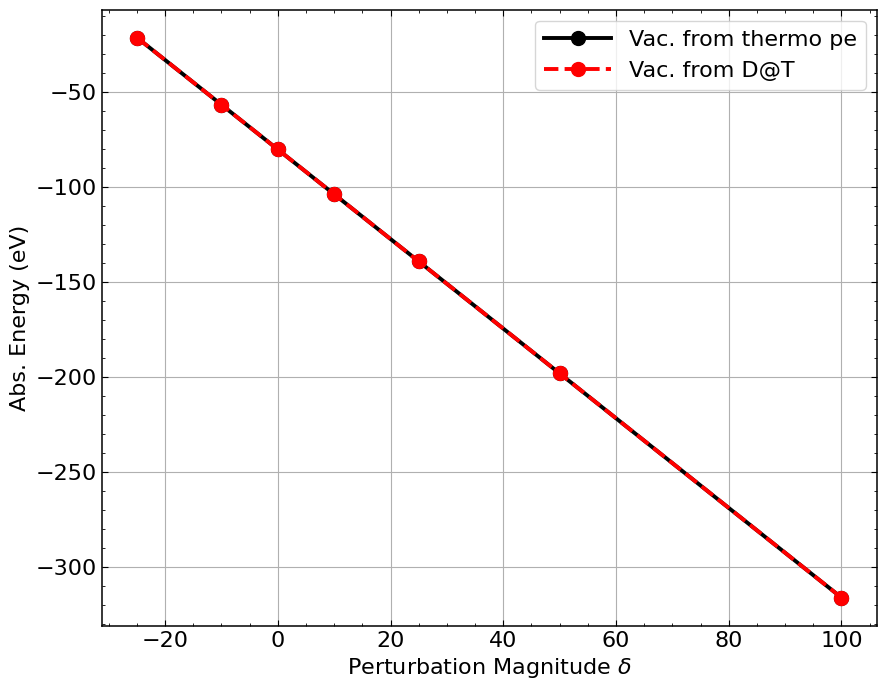

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Absolute energy

ax.plot(delta_array, [bcc_vac_list[i]['energy_test_thermo_pe'] for i in range(ndelta)], label='Vac. from thermo pe', marker='o', c='black')
ax.plot(delta_array, [bcc_vac_list[i]['energy_test_desc'] for i in range(ndelta)], label='Vac. from D@T', marker='o', c='red', ls='--')

ax.set_xlabel('Perturbation Magnitude $\delta$')
ax.set_ylabel('Abs. Energy (eV)')

ax.grid()
ax.legend()

plt.show()

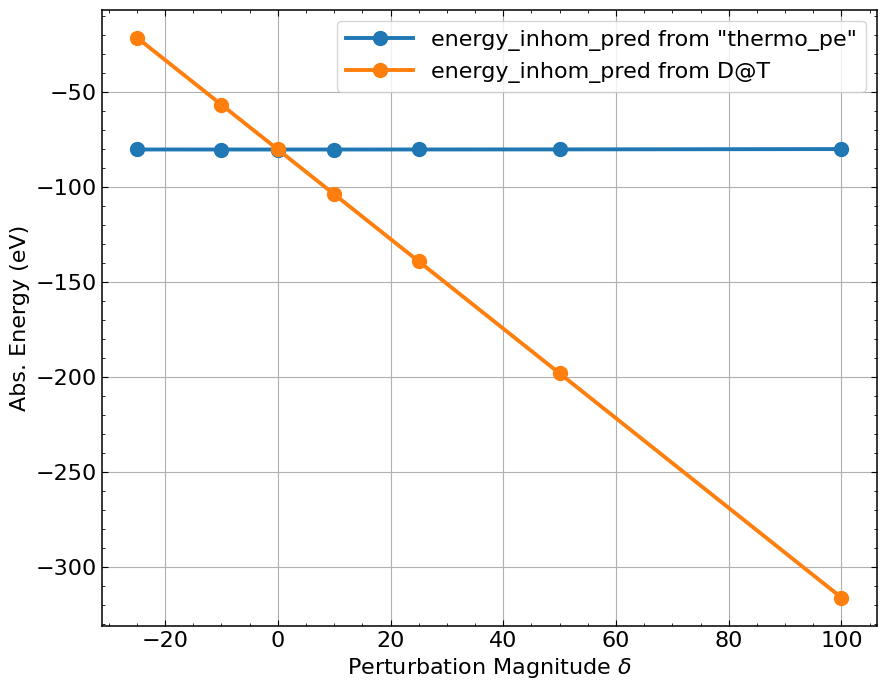

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Absolute energy

ax.plot(delta_array, [bcc_vac_list[i]['energy_inhom_pred'] for i in range(ndelta)], label='energy_inhom_pred from "thermo_pe"', marker='o')
ax.plot(delta_array, [bcc_vac_list[i]['energy_inhom_pred2'] for i in range(ndelta)], label='energy_inhom_pred from D@T', marker='o')

ax.set_xlabel('Perturbation Magnitude $\delta$')
ax.set_ylabel('Abs. Energy (eV)')

ax.grid()
ax.legend()

plt.show()

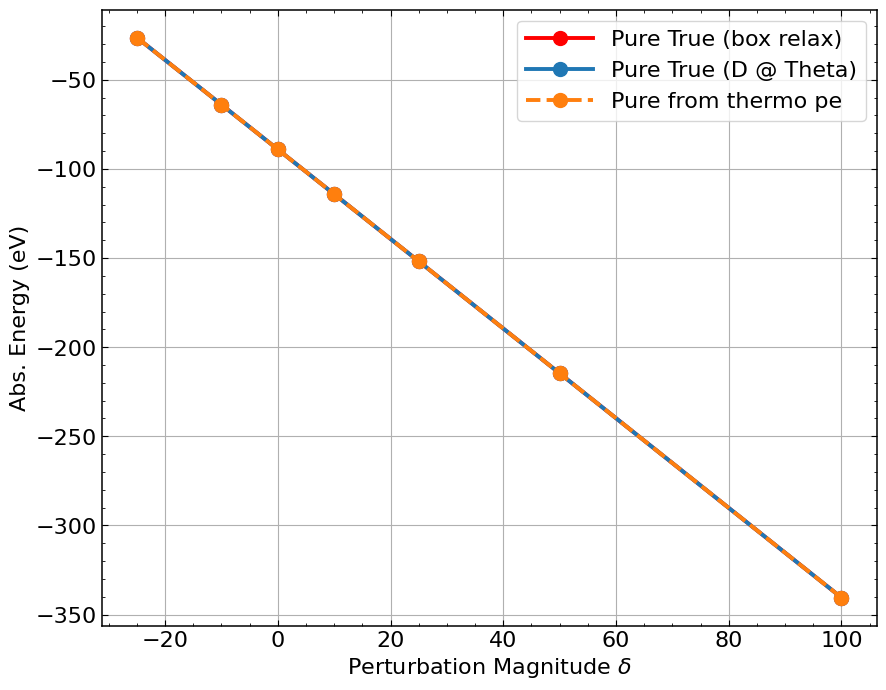

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Absolute energy

ax.plot(delta_array, [bcc_pure_list[i]['energy_true'] for i in range(ndelta)], label='Pure True (box relax)', marker='o', c='red')

ax.plot(delta_array, [bcc_pure_list[i]['energy_true2'] for i in range(ndelta)], label='Pure True (D @ Theta)', marker='o')

ax.plot(delta_array, [bcc_pure_list[i]['energy_true3'] for i in range(ndelta)], label='Pure from thermo pe', marker='o', ls='--')


ax.set_xlabel('Perturbation Magnitude $\delta$')
ax.set_ylabel('Abs. Energy (eV)')

ax.grid()
ax.legend()

plt.show()

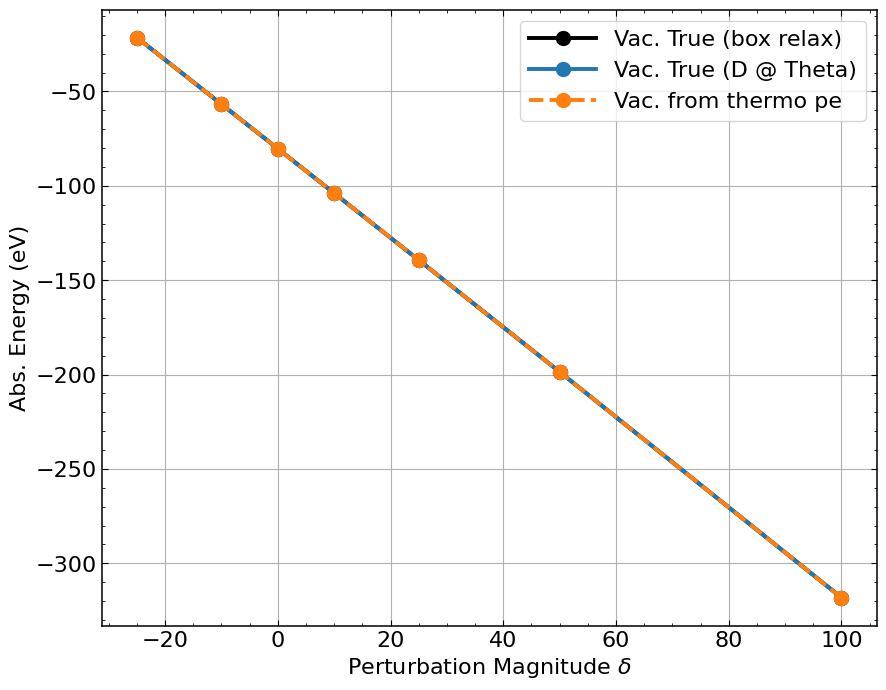

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Absolute energy

ax.plot(delta_array, [bcc_vac_list[i]['energy_true'] for i in range(ndelta)], label='Vac. True (box relax)', marker='o', c='black')

ax.plot(delta_array, [bcc_vac_list[i]['energy_true2'] for i in range(ndelta)],label='Vac. True (D @ Theta)', marker='o')

ax.plot(delta_array, [bcc_vac_list[i]['energy_true3'] for i in range(ndelta)], label='Vac. from thermo pe', marker='o', ls='--')


ax.set_xlabel('Perturbation Magnitude $\delta$')
ax.set_ylabel('Abs. Energy (eV)')

ax.grid()
ax.legend()

plt.show()


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log tmp.log

Setting SNAP potential

                  SNAP coefficients for: W
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Number of atoms: 15, largest force value: 2.094e-01, force norm: 1.026e+00
system_tmp.pot.Theta_dict['W']['beta0']=0.0


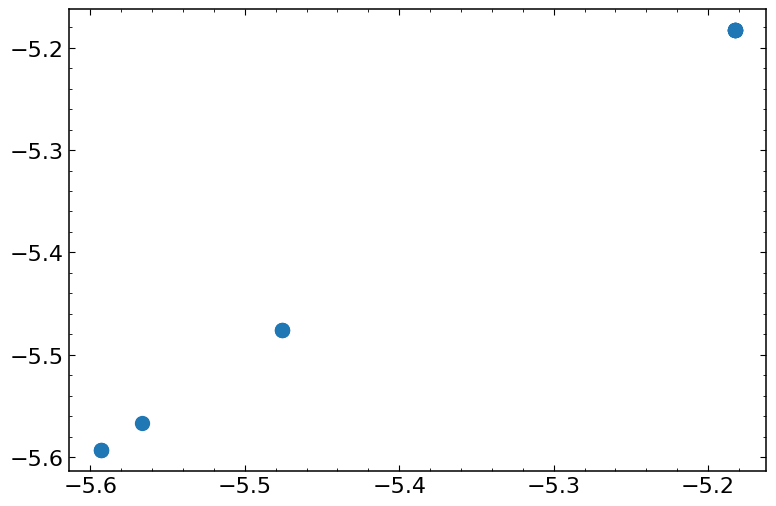

[ 1.44887049e-02  5.68275404e-02  2.70651898e-01  3.15909063e-02
  5.16003146e-01  4.36935648e-02  1.72493794e-01  3.70922674e-02
  9.34896495e-02  1.98830291e-01  8.16021466e-02  3.05961634e-02
 -2.24082501e-02  1.31361895e-02  3.38972567e-02  1.14458446e-02
  9.31186772e-02  7.60949724e-03 -1.18627708e-02 -8.63391642e-03
 -7.74311666e-03  1.60907404e-03 -2.78140780e-03  6.43830873e-02
  5.49095992e-02  5.28363978e-02  2.99793941e-02  2.63064215e-04
 -5.46351793e-03  2.80855206e-02 -1.46769045e-02  1.07484615e-02
 -1.07423938e-02  1.53492283e-02  5.14390187e-02  2.33066906e-02
  3.07246652e-02  5.35290315e-03  1.83481728e-02  1.41723152e-03
 -1.00347980e-03 -2.59615202e-03 -7.89300076e-03  1.98761314e-02
  3.01750889e-02 -4.64729843e-04 -2.97040461e-04  7.20382719e-04
  9.72460481e-03  4.78621891e-03 -2.22583474e-03  6.47170981e-03
  2.91565347e-03 -2.58140611e-03  1.12088430e-03]
********************************************************************************
energy_c_E=array([-5.182

In [23]:
delta = 10.0
sample = 1
data_path = '../lammps_implicit_der/data_files/'
# system_tmp is created only to save the SNAP potential files
system_tmp = BccVacancy(data_path=data_path, snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                            ncell_x=ncell_x, alat=alat, logname='tmp.log', minimize=False, verbose=True)

print(f"{system_tmp.pot.Theta_dict['W']['beta0']=}")
system_tmp.scatter_coord()
system_tmp.gather_D_dD()
energy_thermo_pe0 = system_tmp.energy
energy_desc0 = system_tmp.dU_dTheta @ system_tmp.Theta #system_tmp.pot.Theta_dict['W']['Theta']

energy_c_E = system_tmp.lmp.gather("c_E", 1, 1)
c_D = np.ctypeslib.as_array(system_tmp.lmp.gather("c_D", 1, 55)).reshape(-1, 55)

energy_c_E = np.ctypeslib.as_array(energy_c_E)

plt.scatter(energy_c_E, c_D@system_tmp.Theta)
plt.show()

print(system_tmp.Theta)

print('*'*80)
print(f'{energy_c_E=}')
print(f'{energy_thermo_pe0=}, {energy_desc0=}')
print('*'*80)

In [24]:

element = system_tmp.pot.elem_list[0]
Theta_perturb = Theta_ens['Theta_mean'] + delta * (Theta_ens['Theta_ens_list'][sample] - Theta_ens['Theta_mean'])

# Set the perturbed parameters
system_tmp.pot.Theta_dict[element]['Theta'] = Theta_perturb
system_tmp.pot.to_files(path='.', overwrite=True, snapcoeff_filename='perturb.snapcoeff', snapparam_filename='perturb.snapparam', verbose=True)

# Create the perturbed system with the new potential
system_perturb = BccVacancy(ncell_x=ncell_x, alat=alat, logname='test.log', minimize=True, verbose=True,
                                snapcoeff_filename='perturb.snapcoeff', snapparam_filename='perturb.snapparam', fix_box_relax=False,
                                data_path='.')

energy_thermo_pe = system_perturb.energy
energy_desc = system_perturb.dU_dTheta @ system_perturb.Theta

print('*'*80)
print(f'{energy_thermo_pe=}, {energy_desc=}')
print('*'*80)

Overwriting ./perturb.snapcoeff
Saved SNAP coefficients to ./perturb.snapcoeff
Saved SNAP parameters to ./perturb.snapparam

--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log test.log

Setting SNAP potential

                  SNAP coefficients for: W
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 

Minimization finished in 4 steps
Initial fmax: 1.773e-01, final fmax: 2.093e-11
Initial fnorm: 8.685e-01, final fnorm: 1.025e-10
Number of atoms: 15, largest force value: 2.093e-11, force norm: 1.025e-10
********************************************************************************
energy_thermo_pe=-103.7473350127779, energy_desc=-103.74733501277788
**********************************************************